# Analyzing sales and performance data

With this project we are going to analyze data from chinook database, primarily using SQL for the analysis and using different strategies to simulate real-life scenarios. A schema of the data was procured for the project

![image.png](Images/Chinook_Database_Schema.png)

In [2]:
%%capture
%load_ext sql
%sql sqlite:///chinook-unmodified.db

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp
from matplotlib import cm
from matplotlib.colors import ListedColormap
import numpy as np
import sqlite3
import seaborn as sns
from numpy import arange

In [4]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook-unmodified.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


## Which albums should be purchased

The Chinook record store is considering signing a deal with a new company that especialises in Metal, Alternative and Punk, Jazz and Blues. Before devoting more time into discussing the deal, we have tasked by management with finding out whether or not this agreement could be profitable based off on the sales of these particular genres

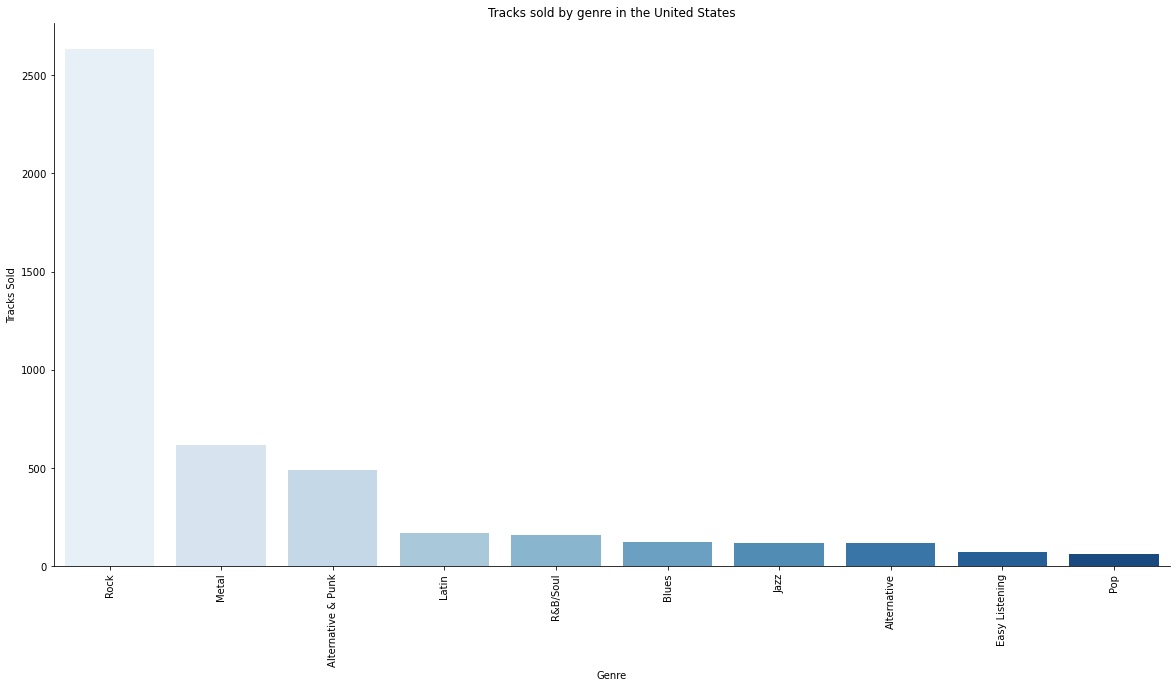

In [5]:
%matplotlib inline
conn = sqlite3.connect("chinook-unmodified.db")
query = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
   )
SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
'''
data = pd.read_sql_query(query, conn)
tick_positions = range(1, len(data['genre']))
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
sns.barplot(x = data['genre'][0:10], y = data['tracks_sold'][0:10], palette = 'Blues', ax = ax)
sns.despine()
plt.title('Tracks sold by genre in the United States')
ax.set_xlabel('Genre')
ax.set_ylabel('Tracks Sold')
plt.xticks(np.arange(len(data['genre'][0:10])), data['genre'], rotation = 90)
plt.show()

Based on these results we would recommend the following genres for the purchase of albums: Punk, Blues and Jazz as these among the options provided are the ones that sold the best. However, before taking the decision in firm, it would be good to look at the percentage of sales amassed by these genres

C:\Users\danif\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


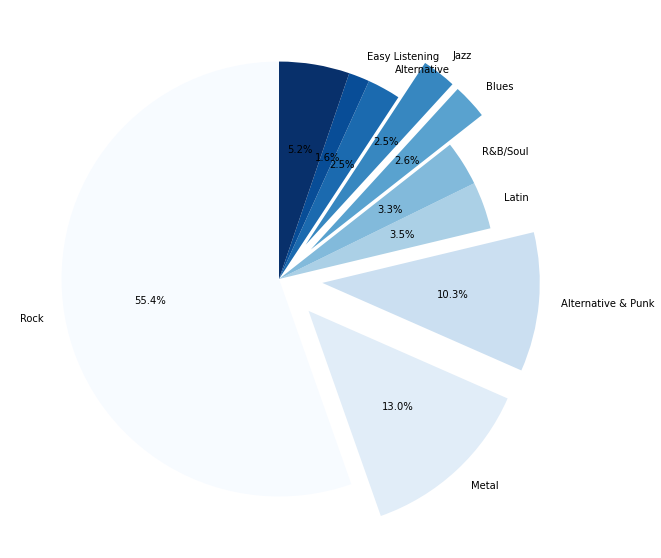

In [23]:
%matplotlib inline
def reclassification(row):
    if row < 0.015:
        return 'Other' 

data['genre'][9:] = data['percentage_sold'][9:].apply(reclassification)
color = cm.get_cmap('Blues', len(data['genre']))
new_color = color(np.linspace(0,1,len(data['genre'])))
sum_other = data.loc[data['genre'] == 'Other', 'percentage_sold'].sum(axis = 0)
data.loc[data['genre'] == 'Other', 'percentage_sold'] = sum_other
data.loc[data['genre'] == 'Other', 'tracks_sold'] = data.loc[data['genre'] == 'Other', 'tracks_sold'].sum(axis = 0)
data.drop_duplicates(['genre', 'tracks_sold', 'percentage_sold'], inplace = True, keep = 'first')



fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
explode = (0, 0.2, 0.2, 0, 0, 0.2, 0.2, 0, 0, 0)
ax.pie(data['percentage_sold'], explode = explode, 
       autopct = '%1.1f%%', labels = data['genre'], startangle = 90, colors = new_color)
mlp.style.use('default')
plt.show()

These genres make up ~28% of sales combined, and taking this data into account I consider the deal as profitable enough to continue in talks

## Sales support agent's performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase.  Now we are going to evaluate the performance of each employee to see how much they have sold and how they compare with their peers

In [7]:
%%sql
WITH 
    total_purchased AS 
    (
    SELECT 
        c.*,
        SUM(i.total) total
        FROM customer c
        INNER JOIN invoice i ON i.customer_id = c.customer_id
        GROUP BY c.customer_id
    ),
    total_employees AS (
        SELECT 
            COUNT(DISTINCT(e.employee_id))
        FROM employee e
    )
SELECT
    t.support_rep_id employee_id,
    e.first_name || ' ' || e.last_name employee_name,
    e.hire_date hired,
    e.country,
    SUM(t.total) total_purchases
    FROM total_purchased t
    LEFT JOIN employee e ON e.employee_id = t.support_rep_id
    GROUP BY employee_id

 * sqlite:///chinook-unmodified.db
Done.


employee_id,employee_name,hired,country,total_purchases
3,Jane Peacock,2017-04-01 00:00:00,Canada,1731.5099999999998
4,Margaret Park,2017-05-03 00:00:00,Canada,1584.0000000000002
5,Steve Johnson,2017-10-17 00:00:00,Canada,1393.92


Each sales agent has more than \$1000 in sales. While there is a difference of approximately 20% from Jane Peacock to Steve Johnson this correlates with the differences in time since they were hired at chinook, hence we can conclude that in these terms all employees perform on the same level on average 

## Value by country

Our next step is to calculate data for each country to compare performance for each one and how our sales are distributed. In particular, we want to understand the following metrics:

   - Total number of customers
   - Total value of sales
   - Average number of order per customer
   - Average order value

To keep our insights useful, any country that has only one customer will be shown through 'Other'

In [8]:
%%sql
WITH cc AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS countries,
       c.*
    FROM customer c
)
    SELECT
    c.countries,
    COUNT(DISTINCT(c.customer_id)) total_customers,
    ROUND(SUM(il.unit_price), 4) total_sales,
    ROUND(SUM(il.unit_price)/COUNT(DISTINCT(i.invoice_id)), 4) Average_orders,
    CAST(SUM(il.unit_price) as Float)/COUNT(DISTINCT(c.customer_id)) Average_order_value,
    CASE
            WHEN countries = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM cc c
    INNER JOIN invoice i ON c.customer_id = i.customer_id
    INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
    GROUP BY 1
    ORDER BY sort ASC, total_sales DESC
;    

 * sqlite:///chinook-unmodified.db
Done.


countries,total_customers,total_sales,Average_orders,Average_order_value,sort
USA,13,1040.49,7.9427,80.03769230769292,0
Canada,8,535.59,7.0472,66.94875000000043,0
Brazil,5,427.68,7.0111,85.53600000000048,0
France,5,389.07,7.7814,77.81400000000042,0
Germany,4,334.62,8.1615,83.6550000000004,0
Czech Republic,2,273.24,9.108,136.62000000000052,0
United Kingdom,3,245.52,8.7686,81.84000000000026,0
Portugal,2,185.13,6.3838,92.56500000000011,0
India,2,183.15,8.7214,91.5750000000001,0
Other,15,1094.94,7.4486,72.99600000000056,1


Based on the table above, we see great potential for growth in the following markets: 

- Germany
- United Kingdom
- Czech Republic

However, it should be taken into account that the amount of data is very low and that under those conditions there is a lot of risk associated with further investment into these countries

## Whole albums purchases vs individual tracks purchases

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- Purchase a whole album
- Purchase a collection of one or more individual tracks.

Management is considering changing their purchasing strategy to save money by buying only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

In order to understand whether or not this strategy could impact revenues significantly, first we need to understand what percentage of purchases are individual tracks vs the percentage of whole album purchases. This will tell us whether or not buying tracks could be a better approach to save costs.

In [9]:
%%sql
WITH invoice_albums AS
    (
     SELECT
        il.invoice_id invoice_id,
        il.track_id,
        t.album_id
        FROM invoice_line il
        INNER JOIN track t ON t.track_id = il.track_id
        
    ),
    total_album AS 
    (
    SELECT 
        invoice_id,
        COUNT(DISTINCT(album_id)) albums_purchased,
        COUNT(DISTINCT(track_id)) tracks_purchased
        FROM invoice_albums
        GROUP BY invoice_id
    ),
    purchases_classification AS(
    SELECT
        *,
        CASE 
            WHEN (albums_purchased = 1 AND tracks_purchased != 1) THEN "album"
        ELSE "track"
        END AS Classification
    FROM total_album)
SELECT 
    Classification,
    COUNT(Classification) Total_Purchases,
    CAST(COUNT(Classification) as Float)/CAST((SELECT COUNT(DISTINCT(invoice_id)) FROM purchases_classification) as Float) Percentaje_Total_Purchases
    FROM purchases_classification
    GROUP BY Classification

 * sqlite:///chinook-unmodified.db
Done.


Classification,Total_Purchases,Percentaje_Total_Purchases
album,133,0.21661237785016288
track,481,0.7833876221498371


By analyzing current trends in sales, we'd found that 21.66% of sales come from selling complete albums instead of tracks. Given that album sales represent such a big part of revenue, we'd recommend the managers to not change the current strategy, as doing so could translate into losing a good percentage of sales

# Is the range of tracks in the store reflective of their sales popularity?

Since the idea of ditching whole album purchases could be too costly, management is considering saving costs instead by looking at the tracks they are currently selling and renovating the license of. Since purchasing and renovating licenses can be very expensive, it would save a lot of money if unpopular tracks' licenses were not renovated.

To understand the potential impact of this measure, first we need to know whether the current catalog reflects the popularity of the songs.

In [10]:
%%sql
WITH total_tracks AS 
    (
        SELECT 
            COUNT(DISTINCT(t.track_id)) total_tracks,
            COUNT(DISTINCT(il.track_id)) sold_tracks,
            CAST(COUNT(DISTINCT(il.track_id)) as Float)/CAST(COUNT(DISTINCT(t.track_id)) as Float) Percentage_sold
        FROM track t
        LEFT JOIN invoice_line il ON t.track_id = il.track_id            
    )
SELECT * FROM total_tracks

 * sqlite:///chinook-unmodified.db
Done.


total_tracks,sold_tracks,Percentage_sold
3503,1806,0.5155580930630888


Only around ~52% of tracks available in the store have been sold at least once, which means that a significant proportion of the selection has never been purchased. Of those, it is imperative to understand how many are protected media with licenses the store has to pay for and renovate. It would also be good to understand the least popular genres, that way we will know which purchases to avoid in the future.

In [11]:
%%sql
WITH individual_purchases AS
    (SELECT 
         t.track_id available_tracks_id,
         m.name protection,
         COUNT(il.track_id) tracks_sales
     FROM track t
        LEFT JOIN invoice_line il ON t.track_id = il.track_id
        LEFT JOIN media_type m ON t.media_type_id = m.media_type_id
        LEFT JOIN genre g ON g.genre_id = t.genre_id
     GROUP BY 1
    ), Popularity_classification AS 
    (SELECT 
        *,
        CASE
           WHEN tracks_sales = 0 THEN "Never Sold"
        ELSE "Sold"
        END AS Classification
     FROM individual_purchases
     GROUP BY available_tracks_id)
SELECT 
    protection, 
    COUNT(protection) Number_of_tracks,
    Classification
    FROM Popularity_classification
    GROUP BY protection, Classification

 * sqlite:///chinook-unmodified.db
Done.


protection,Number_of_tracks,Classification
AAC audio file,3,Never Sold
AAC audio file,8,Sold
MPEG audio file,1393,Never Sold
MPEG audio file,1641,Sold
Protected AAC audio file,86,Never Sold
Protected AAC audio file,151,Sold
Protected MPEG-4 video file,211,Never Sold
Protected MPEG-4 video file,3,Sold
Purchased AAC audio file,4,Never Sold
Purchased AAC audio file,3,Sold


Looking at the table above, there are three striking characteristics worth noticing: Protected files are less popular than unprotected ones when controlling for availability, second is that Protected MPEG-4 video files seem to be media type that fares the worse with customers, having only sold 3 out of 214 in the inventory. The third insight is that around 45% of MPEG audio files available in the store have never been purchased

The next step in our analysis is to look at genres of the tracks that have never been purchased by our customers. This way we will be able to tell where we could save money by cancelling licenses that could be redirected to purchasing tracks that are more in tune with our customer base.

In [12]:
%%sql
WITH individual_purchases AS
    (SELECT 
         t.track_id available_tracks_id,
         m.name protection,
         COUNT(il.track_id) tracks_sales
     FROM track t
        LEFT JOIN invoice_line il ON t.track_id = il.track_id
        LEFT JOIN media_type m ON t.media_type_id = m.media_type_id
     GROUP BY 1
    ), Popularity_classification AS 
    (SELECT 
        *,
        CASE
           WHEN tracks_sales = 0 THEN "Never Sold"
        ELSE "Sold"
        END AS Classification
     FROM individual_purchases
     GROUP BY available_tracks_id
    ), genres_not_purchased AS 
    (SELECT
        p.available_tracks_id,
        p.protection,
        p.tracks_sales,
        p.Classification,
        g.name genre
     FROM Popularity_classification p
     INNER JOIN track t ON t.track_id = p.available_tracks_id
     LEFT JOIN genre g ON g.genre_id = t.genre_id
    ), genres_total AS
    (SELECT 
         genre,
         COUNT(genre) total
         FROM genres_not_purchased
         GROUP BY 1)
SELECT 
    g.genre,
    COUNT(g.genre) total_not_sold,
    gt.total total_tracks_by_genre,
    (CAST(COUNT(g.genre) as Float)/CAST(gt.total as Float))*100 percentage_not_sold
    FROM genres_not_purchased g
    INNER JOIN genres_total gt ON g.genre = gt.genre
    WHERE Classification = 'Never Sold'
    GROUP BY 1
    ORDER BY percentage_not_sold DESC
    LIMIT 15;

 * sqlite:///chinook-unmodified.db
Done.


genre,total_not_sold,total_tracks_by_genre,percentage_not_sold
World,28,28,100.0
Science Fiction,13,13,100.0
Sci Fi & Fantasy,26,26,100.0
Rock And Roll,12,12,100.0
Opera,1,1,100.0
Comedy,17,17,100.0
Bossa Nova,15,15,100.0
Drama,63,64,98.4375
TV Shows,91,93,97.84946236559139
Soundtrack,38,43,88.37209302325581


Looking at the table above, it is recommended that management consider removing all genres that haven't sold more than 90% of its tracks and freezing acquisitions for anything over 75%. That way the business could center its efforts into acquiring tracks for genres that do well with our customers and attract more by adding novelty to our selection.

It should be taken into account, however, that currently Chinook has a very relatively small number of clients and that preferences could change or deepen with time, so this topic should be revisited at a later date

In [13]:
%%sql
SELECT 
    COUNT(DISTINCT(customer_id)) Total_number_of_clients
    FROM customer

 * sqlite:///chinook-unmodified.db
Done.


Total_number_of_clients
59


# Most popular artist

In a scheme to attract more clients, management is considering offering a coupon to purchase tracks from certain artists based on referrals made by potential customers for a limited amount of time. The coupon should be attractive enough -both in monetary terms and on artistic terms- to generate sales, but not significative enough that it would damage revenue significatively in case it goes wrong.

After some consideration, management decides that it will allocate a total of $5000 into the coupon scheme, leaving up to the analyst to decide how much the coupon should be worth and how many to  produce. It is also up to the analyst to decide on which artists to apply the discount, while the referral scheme is left to the marketing department.

With that information the first step in the analysis should be to determine the most popular artists in our current customer base. To do so would be to extract the artists from the most sold tracks and display them accordingly. Since management didn't especify how many artists should be targeted with our plan, we decide to set the number to the most popular 25

In [14]:
%%sql
WITH individual_purchases AS
    (SELECT 
         ar.name,
         COUNT(il.track_id) tracks_sales
     FROM track t
        LEFT JOIN invoice_line il ON t.track_id = il.track_id
        INNER JOIN album al ON t.album_id = al.album_id
        INNER JOIN artist ar ON ar.artist_id = al.album_id
     GROUP BY 1
     ORDER BY 2 DESC
     LIMIT 25
    )
SELECT * FROM individual_purchases

 * sqlite:///chinook-unmodified.db
Done.


name,tracks_sales
Pink Floyd,187
Guns N' Roses,96
"Richard Marlow & The Choir of Trinity College, Cambridge",93
Peter Tosh,90
Academy of St. Martin in the Fields & Sir Neville Marriner,83
Charlie Brown Jr.,80
Alice In Chains,80
Academy of St. Martin in the Fields Chamber Ensemble & Sir Neville Marriner,80
Corinne Bailey Rae,78
Sir Georg Solti & Wiener Philharmoniker,76


With the list of artist defined, the next step is to define the coupon value and how many should be allocated to each artist to achieve the best results

Since we know that all tracks in the store are sold at the same price ($0.99) and that the cuopon shouldn't be too big as to damage revenues too much but big enough to attract clients into the store, we settle for a coupon worth 0.19(~24\%) that leaves the final price of the tracks at 0.80 and allows us to issue 6250 cuopons to our clients, 250 per artist.